In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import math

## Read the train, validation and test data with predictions

In [2]:
data_train = pd.read_csv('../data/data_train.csv')
data_val = pd.read_csv('../data/data_val.csv')
data_test = pd.read_csv('../data/data_test.csv')


In [3]:
data_train[['Open', 'High', 'pred_high_open', 'actual_high_open', 'Low', 'pred_low_open', 'actual_low_open',  'Close', ]]

,Open,High,pred_high_open,actual_high_open,Low,pred_low_open,actual_low_open,Close
0,546.000000,548.000000,1.379346,2.000000,541.359985,-4.966847,-4.640015,544.159973
1,546.559998,547.119995,1.550162,0.559997,538.400024,-0.807878,-8.159974,545.599976
2,545.760010,550.479980,2.233621,4.719970,542.479980,-0.433728,-3.280030,542.719971
3,553.599976,559.200012,4.208293,5.600036,549.440002,-6.115969,-4.159974,558.320007
4,560.799988,568.400024,5.000463,7.600036,556.559998,-4.734383,-4.239990,566.000000
...,...,...,...,...,...,...,...,...
2480,79.370003,81.750000,5.744164,2.379997,78.940002,-6.572255,-0.430001,81.680000
2481,81.589996,81.980003,5.239764,0.390007,80.169998,-6.595157,-1.419998,80.699997
2482,80.220001,80.269997,6.414516,0.049996,78.349998,-14.311090,-1.870003,78.889999
2483,78.040001,78.220001,0.367928,0.180000,76.309998,-0.985570,-1.730003,76.930000


## Helper Function: Finding the best delta for any given strategy and data

In [22]:
def plot_best_delta_strategy(data, tune=True, strategy="blind", optimize="sharpe_ratio", delta_percents=np.arange(0, 0.02, 0.0001), verbose=False, plot_capital=False):

    if tune:
        print(f"Exploring various deltas for the {strategy} strategy....")

        best_sharpe_ratio = None
        best_avg_pnl = None
        best_std_pnl = None
        best_delta_percent = None
        best_pnl = None
        best_profit_days = None
        best_loss_days = None
        best_neutral_days = None
        best_capital = None

        if optimize == "sharpe_ratio":
            best_sharpe_ratio = -1 * float('inf')
        
        elif optimize == "capital":
            best_capital = -1 * float('inf')

        elif optimize == "avg_pnl":
            best_avg_pnl = -1 * float('inf')

        elif optimize == "std_pnl":
            best_std_pnl = -1 * float('inf')

        else:
            print('The optimize parameter should be one of sharpe_ratio, capital, avg_pnl, or std_pnl')
            return


        for delta_percent in delta_percents:
            if strategy == "blind":
                pnl, num_profit_days, num_loss_days, num_neutral_days, capital = blind_strat(data, delta_percent=delta_percent)
            elif strategy == "stoploss":
                pnl, num_profit_days, num_loss_days, num_neutral_days, capital = stoploss_strat(data, delta_percent=delta_percent)
            elif strategy == "long_short":
                pnl, num_profit_days, num_loss_days, num_neutral_days, capital = long_short_strat(data, delta_percent=delta_percent)
            else:
                print('The strategy parameter should be one of blind, stoploss, or long_short.')
                return
        
            avg_pnl = np.mean(pnl)
            std_pnl = np.std(pnl)

            # Assuming a risk-free rate of 0!
            sharpe_ratio = avg_pnl / std_pnl     

            if optimize == 'sharpe_ratio':

                if sharpe_ratio > best_sharpe_ratio:
                    best_sharpe_ratio = sharpe_ratio
                    best_avg_pnl = avg_pnl
                    best_std_pnl = std_pnl
                    best_capital = capital
                    best_delta_percent = delta_percent
                    best_profit_days = num_profit_days
                    best_loss_days = num_loss_days
                    best_neutral_days = num_neutral_days
                    best_pnl = pnl

                if verbose:
                    print(f"""For Delta = {delta_percent*100}% ===> Sharpe Ratio = {sharpe_ratio}""")
                
            if optimize == 'capital':

                if capital > best_capital:
                    best_sharpe_ratio = sharpe_ratio
                    best_avg_pnl = avg_pnl
                    best_std_pnl = std_pnl
                    best_capital = capital
                    best_delta_percent = delta_percent
                    best_profit_days = num_profit_days
                    best_loss_days = num_loss_days
                    best_neutral_days = num_neutral_days
                    best_pnl = pnl

                if verbose:
                    print(f"""For Delta = {delta_percent*100}% ===> Capital = {capital}""")
            
            if optimize == 'avg_pnl':

                if avg_pnl > best_avg_pnl:
                    best_sharpe_ratio = sharpe_ratio
                    best_avg_pnl = avg_pnl
                    best_std_pnl = std_pnl
                    best_capital = capital
                    best_delta_percent = delta_percent
                    best_profit_days = num_profit_days
                    best_loss_days = num_loss_days
                    best_neutral_days = num_neutral_days
                    best_pnl = pnl

                if verbose:
                    print(f"""For Delta = {delta_percent*100}%, ===> Average PNL = {avg_pnl}""")
                
            if optimize == "std_pnl":
                if std_pnl > best_std_pnl:
                    best_sharpe_ratio = sharpe_ratio
                    best_avg_pnl = avg_pnl
                    best_std_pnl = std_pnl
                    best_capital = capital
                    best_delta_percent = delta_percent
                    best_profit_days = num_profit_days
                    best_loss_days = num_loss_days
                    best_neutral_days = num_neutral_days
                    best_pnl = pnl

                if verbose:
                    print(f"""For Delta = {delta_percent*100}% ===> Std PNL = {std_pnl}""")
            
        print()

        if optimize == 'sharpe_ratio':
            print(f"""Best Delta for {strategy} Strategy = {best_delta_percent*100}%,
                ===> Best Sharpe Ratio = {best_sharpe_ratio:3f}
                ===> Sum PnL = {sum(best_pnl):3f}
                ===> Average PNL = {best_avg_pnl:3f}$
                ===> Std PNL = {best_std_pnl:3f}
                ===> Final Capital = {best_capital:3f}$
                ===> Profitable Days = {best_profit_days}
                ===> Lossy Days = {best_loss_days}
                ===> Neutral Days = {best_neutral_days}
                """)
            
        elif optimize == 'capital':
            print(f"""Best Delta for {strategy} Strategy = {best_delta_percent*100}%,
                ===> Sharpe Ratio = {best_sharpe_ratio:3f}
                ===> Sum PnL = {sum(best_pnl):3f}
                ===> Average PNL = {best_avg_pnl:3f}$
                ===> Std PNL = {best_std_pnl:3f}
                ===> Best Final Capital = {best_capital:3f}$
                ===> Profitable Days = {best_profit_days}
                ===> Lossy Days = {best_loss_days}
                ===> Neutral Days = {best_neutral_days}
                """)
            
        elif optimize == 'avg_pnl':
            print(f"""Best Delta for {strategy} Strategy = {best_delta_percent*100}%,
                ===> Sharpe Ratio = {best_sharpe_ratio:3f}
                ===> Sum PnL = {sum(best_pnl):3f}
                ===> Best Average PNL = {best_avg_pnl:3f}$
                ===> Std PNL = {best_std_pnl:3f}
                ===> Final Capital = {best_capital:3f}$
                ===> Profitable Days = {best_profit_days}
                ===> Lossy Days = {best_loss_days}
                ===> Neutral Days = {best_neutral_days}
                """)
        
        elif optimize == 'std_pnl':
            print(f"""Best Delta for {strategy} Strategy = {best_delta_percent*100}%,
                ===> Sharpe Ratio = {best_sharpe_ratio:3f}
                ===> Sum PnL = {sum(best_pnl):3f}
                ===> Average PNL = {best_avg_pnl:3f}$
                ===> Best Std PNL = {best_std_pnl:3f}
                ===> Final Capital = {best_capital:3f}$
                ===> Profitable Days = {best_profit_days}
                ===> Lossy Days = {best_loss_days}
                ===> Neutral Days = {best_neutral_days}
                """)

        plt.title(f'P&L Plot for Delta = {best_delta_percent*100}%')
        plt.xlabel('Days')
        plt.ylabel('P&L in U.S. Dollars $')
        plt.plot(best_pnl)

        return best_pnl

    else:
        delta_percent = delta_percents[0]
        if strategy == "blind":
            pnl, num_profit_days, num_loss_days, num_neutral_days, capital = blind_strat(data, delta_percent=delta_percent, plot_capital=plot_capital)  
        elif strategy == "stoploss":
            pnl, num_profit_days, num_loss_days, num_neutral_days, capital = stoploss_strat(data, delta_percent=delta_percent, plot_capital=plot_capital)  
        elif strategy == "long_short":
            pnl, num_profit_days, num_loss_days, num_neutral_days, capital = long_short_strat(data, delta_percent=delta_percent,plot_capital=plot_capital)
        else:
            print('The strategy parameter should be one of blind, stoploss, or long_short.')
            return

        avg_pnl = np.mean(pnl)
        std_pnl = np.std(pnl)

        # Assuming a risk-free rate of 0!
        sharpe_ratio = avg_pnl / std_pnl  

        print(f"""Delta for {strategy} Strategy = {delta_percent*100}%,
        ===> Sharpe Ratio = {sharpe_ratio:3f}
        ===> Sum PnL = {sum(pnl):3f}
        ===> Average PNL = {avg_pnl:3f}$
        ===> Std PNL = {std_pnl:3f}
        ===> Final Capital = {capital:3f}$
        ===> Profitable Days = {num_profit_days}
        ===> Lossy Days = {num_loss_days}
        ===> Neutral Days = {num_neutral_days}
        """)

        plt.title(f'P&L Plot for Delta = {delta_percent*100}%')
        plt.xlabel('Days')
        plt.ylabel('P&L in U.S. Dollars $')
        plt.plot(pnl)

        return pnl

## Strategies

### Blind Strat

In [32]:
def blind_strat(df, delta_percent=0.0001, cap_alloc_limit=0.5, max_cap_alloc=50000, plot_capital=False, initial_capital=10000):
    pnl = []

    capital = initial_capital

    num_profit_days = 0
    num_loss_days = 0
    num_neutral_days = 0

    capital_list = []

    for day, day_info in df.iterrows():
        # Sell at high else close strat
        predicted_delta = day_info['pred_high_open']
        actual_delta = day_info['actual_high_open']
        open = day_info['Open']
        close = day_info['Close']
        delta = delta_percent * open
        
        # If our prediction is greater than the threshold, trade
        day_return = 0
        
        if predicted_delta >= delta:
            
            # If we hit our high, then sell
            if actual_delta >= predicted_delta:
                day_return = predicted_delta

                # Shouldn't be able to invest beyond max_cap_alloc
                capital_to_invest = min(capital * cap_alloc_limit, max_cap_alloc)

                # Shares to trade
                num_shares = math.floor(capital_to_invest / open)
                capital += num_shares * day_return
                
                pnl.append(predicted_delta)
            else:
                # Else, sell at close
                day_return = open-close
                
                # Shouldn't be able to invest beyond max_cap_alloc
                capital_to_invest = min(capital * cap_alloc_limit, max_cap_alloc)

                # Shares to trade
                num_shares = math.floor(capital_to_invest / open)
                capital += num_shares * day_return
                
                pnl.append(open-close)

            if day_return > 0:
                num_profit_days += 1
            elif day_return < 0:
                num_loss_days += 1
            else:
                num_neutral_days += 1

        else:
            pnl.append(0)
            num_neutral_days += 1
        
        capital_list.append(capital)
    
    if plot_capital:
        plt.plot(capital_list)
        plt.title("Capital Over Time")
        plt.xlabel('Days')
        plt.ylabel('Capital in U.S. Dollars $')
        plt.show()
        print("Capital =", capital)


    return pnl, num_profit_days, num_loss_days, num_neutral_days, capital

#### Sharpe Ratio Optimization

Exploring various deltas for the blind strategy....

Best Delta for blind Strategy = 0.09000000000000001%,
                ===> Best Sharpe Ratio = 0.413969
                ===> Sum PnL = 2775.612940
                ===> Average PNL = 1.116947$
                ===> Std PNL = 2.698142
                ===> Final Capital = 440923.396572$
                ===> Profitable Days = 1596
                ===> Lossy Days = 547
                ===> Neutral Days = 342
                


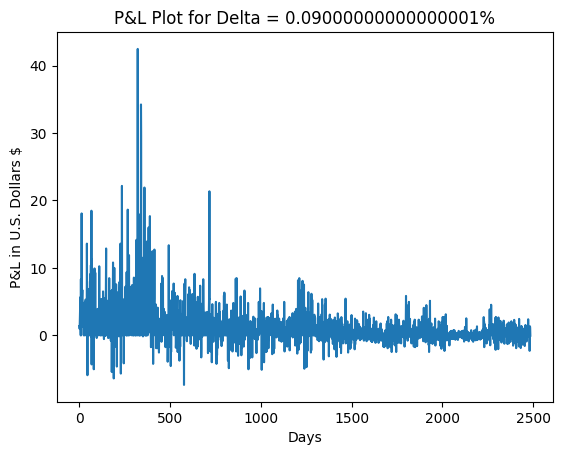

In [33]:
data_train['blind_pnl'] = plot_best_delta_strategy(data=data_train)

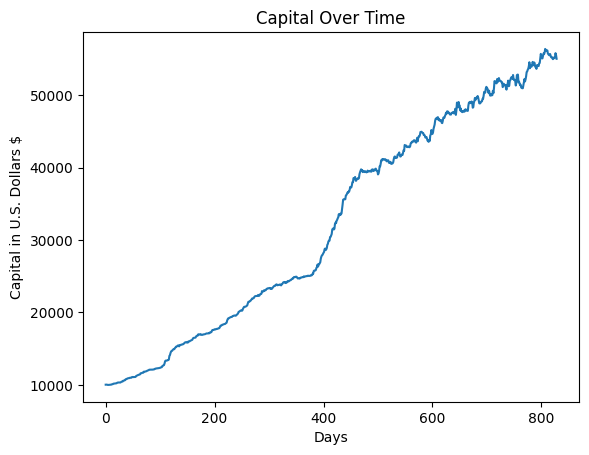

Capital = 55029.89607398869
Delta for blind Strategy = 0.09%,
        ===> Sharpe Ratio = 0.457858
        ===> Sum PnL = 816.400884
        ===> Average PNL = 0.984802$
        ===> Std PNL = 2.150891
        ===> Final Capital = 55029.896074$
        ===> Profitable Days = 507
        ===> Lossy Days = 199
        ===> Neutral Days = 123
        


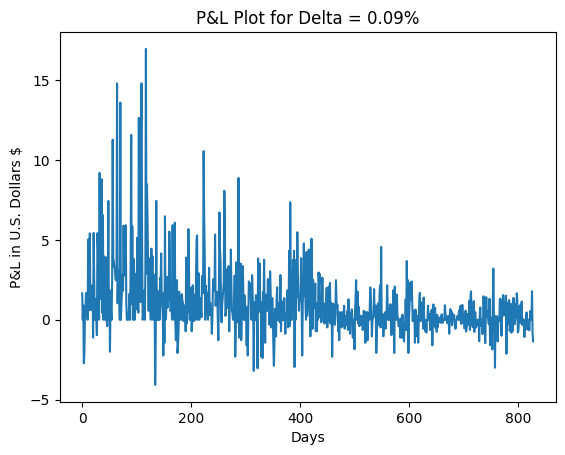

In [34]:
data_val['blind_pnl'] = plot_best_delta_strategy(data=data_val, tune=False, delta_percents=[0.0009], plot_capital=True)

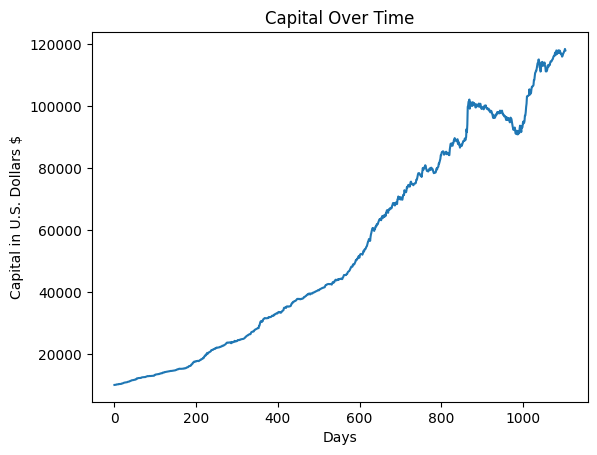

Capital = 118018.32953704963
Delta for blind Strategy = 0.09%,
        ===> Sharpe Ratio = 0.471215
        ===> Sum PnL = 1288.068926
        ===> Average PNL = 1.165673$
        ===> Std PNL = 2.473762
        ===> Final Capital = 118018.329537$
        ===> Profitable Days = 698
        ===> Lossy Days = 244
        ===> Neutral Days = 163
        


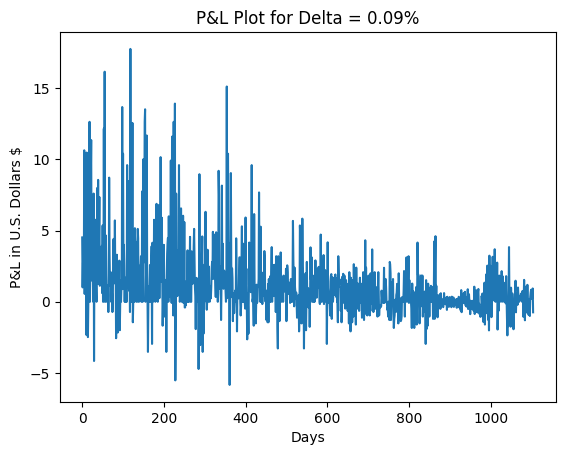

In [35]:
data_test['blind_pnl'] = plot_best_delta_strategy(data=data_test, tune=False, delta_percents=[0.0009], plot_capital=True)

#### Capital Optimization

Exploring various deltas for the blind strategy....

Best Delta for blind Strategy = 0.0%,
                ===> Sharpe Ratio = 0.410628
                ===> Sum PnL = 2818.677500
                ===> Average PNL = 1.134277$
                ===> Std PNL = 2.762295
                ===> Best Final Capital = 444082.011756$
                ===> Profitable Days = 1655
                ===> Lossy Days = 547
                ===> Neutral Days = 283
                


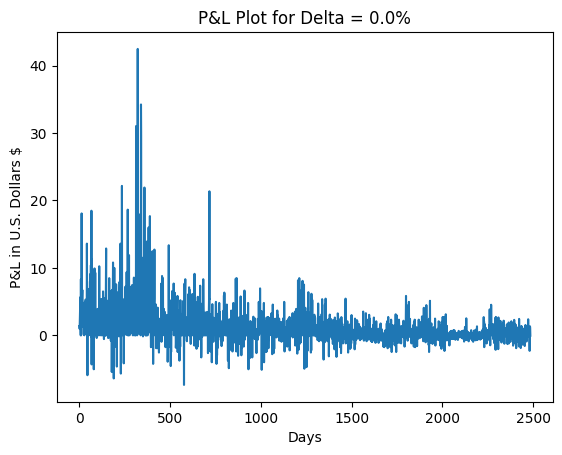

In [36]:
data_train['blind_pnl_capital'] = plot_best_delta_strategy(data=data_train, optimize='capital')

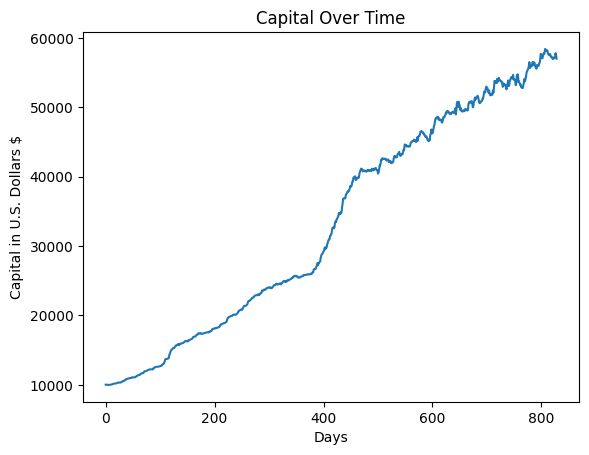

Capital = 56991.01555267399
Delta for blind Strategy = 0%,
        ===> Sharpe Ratio = 0.433633
        ===> Sum PnL = 863.713268
        ===> Average PNL = 1.041874$
        ===> Std PNL = 2.402661
        ===> Final Capital = 56991.015553$
        ===> Profitable Days = 528
        ===> Lossy Days = 199
        ===> Neutral Days = 102
        


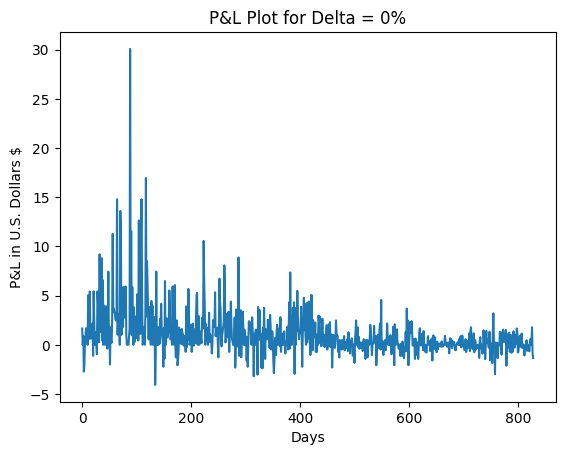

In [37]:
data_val['blind_pnl_capital'] = plot_best_delta_strategy(data=data_val, optimize='capital', tune=False, delta_percents=[0], plot_capital=True)

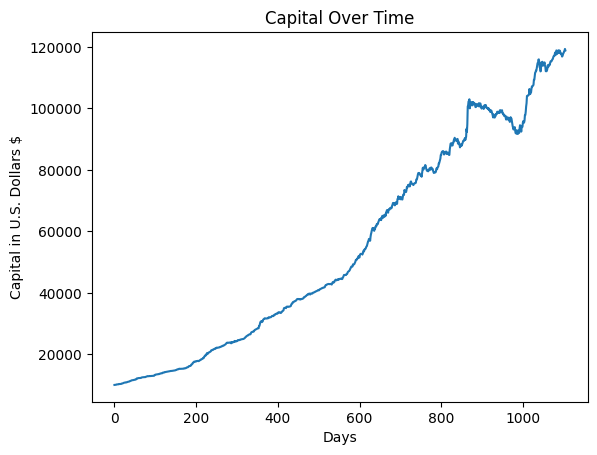

Capital = 118869.97188508397
Delta for blind Strategy = 0%,
        ===> Sharpe Ratio = 0.474141
        ===> Sum PnL = 1294.730513
        ===> Average PNL = 1.171702$
        ===> Std PNL = 2.471212
        ===> Final Capital = 118869.971885$
        ===> Profitable Days = 737
        ===> Lossy Days = 244
        ===> Neutral Days = 124
        


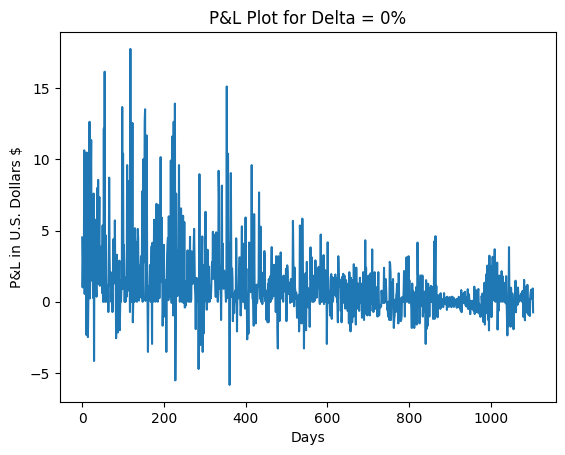

In [38]:
data_test['blind_pnl_capital'] = plot_best_delta_strategy(data=data_test, optimize='capital', tune=False, delta_percents=[0], plot_capital=True)

### Stoploss Strat

In [50]:
def stoploss_strat(df, delta_percent=0.0001, cap_alloc_limit=0.5, max_cap_alloc=50000, plot_capital=False, initial_capital=10000):
    pnl = []

    capital = initial_capital

    num_profit_days = 0
    num_loss_days = 0
    num_neutral_days = 0
    capital_list = []
    for day, day_info in df.iterrows():
        # Sell at high else close strat
        predicted_delta = day_info['pred_high_open']
        actual_delta = day_info['actual_high_open']
        open = day_info['Open']
        close = day_info['Close']
        delta = delta_percent * open

        # If our prediction is greater than the threshold, trade
        day_return = 0
        
        if predicted_delta >= delta:
            
            # If we hit our high, then sell
            if actual_delta >= predicted_delta:
                day_return = predicted_delta
                # Shouldn't be able to invest beyond max_cap_alloc
                capital_to_invest = min(capital * cap_alloc_limit, max_cap_alloc)

                # Shares to trade
                num_shares = math.floor(capital_to_invest / open)
                capital += num_shares * day_return
                
                pnl.append(predicted_delta)

            # Elif Price dips below Open, then sell @ Open
            elif day_info["Low"] < day_info["Open"]:
                day_return = 0
                # Shouldn't be able to invest beyond max_cap_alloc
                capital_to_invest = min(capital * cap_alloc_limit, max_cap_alloc)

                # Shares to trade
                num_shares = math.floor(capital_to_invest / open)
                capital += num_shares * day_return
                
                pnl.append(0)
            else:
                # Else, sell at close
                day_return = open-close
                # Shouldn't be able to invest beyond max_cap_alloc
                capital_to_invest = min(capital * cap_alloc_limit, max_cap_alloc)

                # Shares to trade
                num_shares = math.floor(capital_to_invest / open)
                
                pnl.append(open-close)

            if day_return > 0:
                num_profit_days += 1
            elif day_return < 0:
                num_loss_days += 1
            else:
                num_neutral_days += 1

        else:
            pnl.append(0)
            num_neutral_days += 1
        
        capital_list.append(capital)
        
    if plot_capital:
        plt.plot(capital_list)
        plt.title("Capital Over Time")
        plt.xlabel('Days')
        plt.ylabel('Capital in U.S. Dollars $')
        plt.show()
        print("Capital =", capital)

    return pnl, num_profit_days, num_loss_days, num_neutral_days, capital

#### Sharpe Ratio Optimization

Exploring various deltas for the stoploss strategy....

Best Delta for stoploss Strategy = 0.0%,
                ===> Best Sharpe Ratio = 0.456446
                ===> Sum PnL = 1334.017067
                ===> Average PNL = 0.536828$
                ===> Std PNL = 1.176103
                ===> Final Capital = 152577.857144$
                ===> Profitable Days = 823
                ===> Lossy Days = 20
                ===> Neutral Days = 1642
                


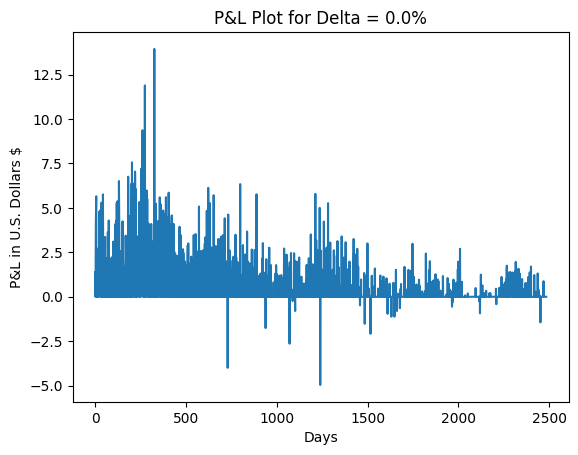

In [41]:
data_train['stoploss_pnl'] = plot_best_delta_strategy(data_train, strategy="stoploss")

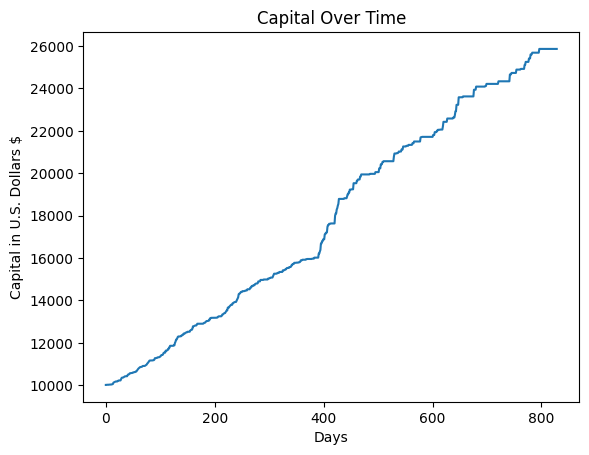

Capital = 25862.431142560952
Delta for stoploss Strategy = 0%,
        ===> Sharpe Ratio = 0.452740
        ===> Sum PnL = 426.623317
        ===> Average PNL = 0.514624$
        ===> Std PNL = 1.136688
        ===> Final Capital = 25862.431143$
        ===> Profitable Days = 272
        ===> Lossy Days = 10
        ===> Neutral Days = 547
        


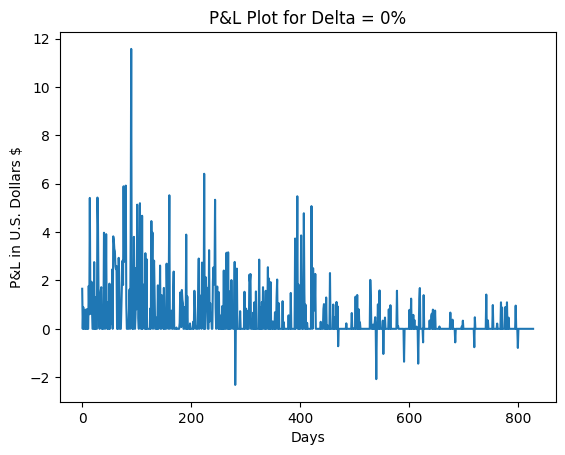

In [44]:
data_val['stoploss_pnl'] = plot_best_delta_strategy(data_val, tune=False, strategy="stoploss", delta_percents=[0], plot_capital=True)

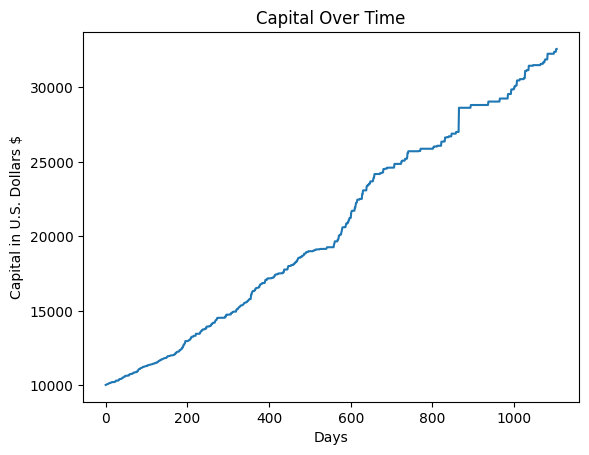

Capital = 32572.03448105819
Delta for stoploss Strategy = 0%,
        ===> Sharpe Ratio = 0.452913
        ===> Sum PnL = 568.750379
        ===> Average PNL = 0.514706$
        ===> Std PNL = 1.136436
        ===> Final Capital = 32572.034481$
        ===> Profitable Days = 356
        ===> Lossy Days = 8
        ===> Neutral Days = 741
        


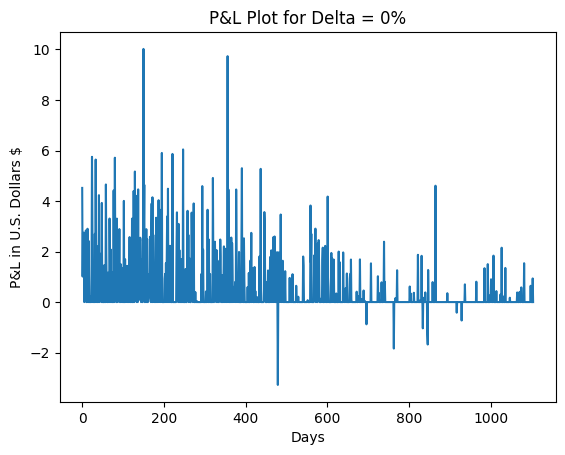

In [46]:
data_test['stoploss_pnl'] = plot_best_delta_strategy(data_test, tune=False, strategy="stoploss", delta_percents=[0], plot_capital=True)

#### Capital Optimization

Exploring various deltas for the stoploss strategy....

Best Delta for stoploss Strategy = 0.0%,
                ===> Sharpe Ratio = 0.456446
                ===> Sum PnL = 1334.017067
                ===> Average PNL = 0.536828$
                ===> Std PNL = 1.176103
                ===> Best Final Capital = 152577.857144$
                ===> Profitable Days = 823
                ===> Lossy Days = 20
                ===> Neutral Days = 1642
                


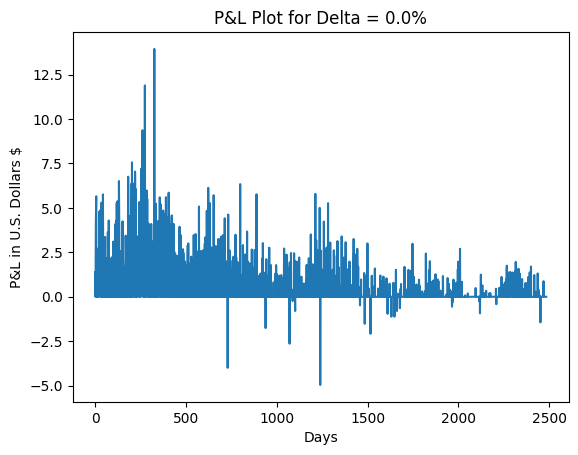

In [47]:
data_train['stoploss_pnl_capital'] = plot_best_delta_strategy(data_train, optimize="capital", strategy="stoploss")

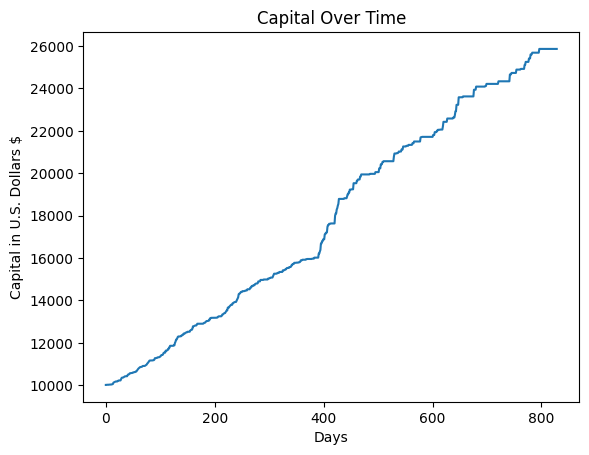

Capital = 25862.431142560952
Delta for stoploss Strategy = 0%,
        ===> Sharpe Ratio = 0.452740
        ===> Sum PnL = 426.623317
        ===> Average PNL = 0.514624$
        ===> Std PNL = 1.136688
        ===> Final Capital = 25862.431143$
        ===> Profitable Days = 272
        ===> Lossy Days = 10
        ===> Neutral Days = 547
        


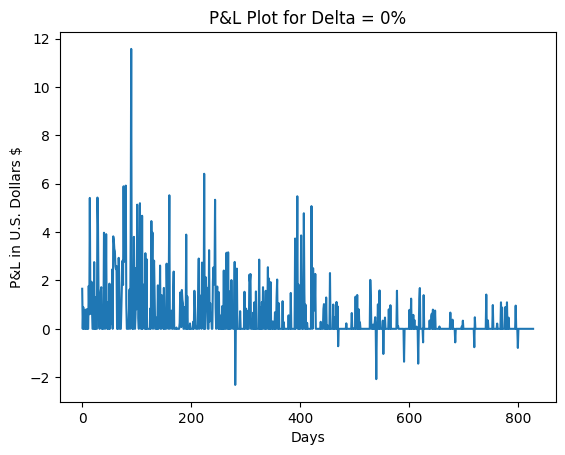

In [48]:
data_val['stoploss_pnl_capital'] = plot_best_delta_strategy(data_val, optimize="capital", tune=False, strategy="stoploss", delta_percents=[0], plot_capital=True)

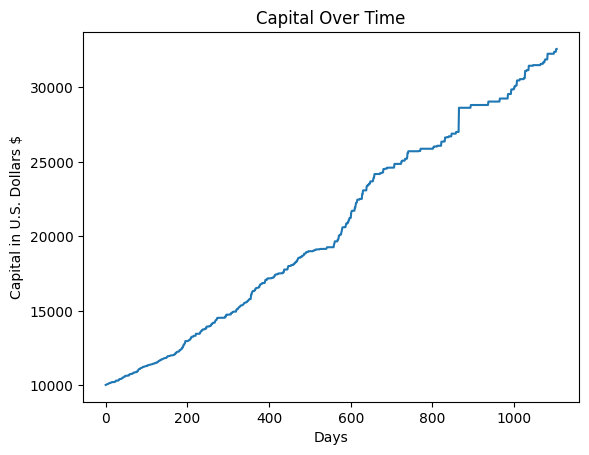

Capital = 32572.03448105819
Delta for stoploss Strategy = 0%,
        ===> Sharpe Ratio = 0.452913
        ===> Sum PnL = 568.750379
        ===> Average PNL = 0.514706$
        ===> Std PNL = 1.136436
        ===> Final Capital = 32572.034481$
        ===> Profitable Days = 356
        ===> Lossy Days = 8
        ===> Neutral Days = 741
        


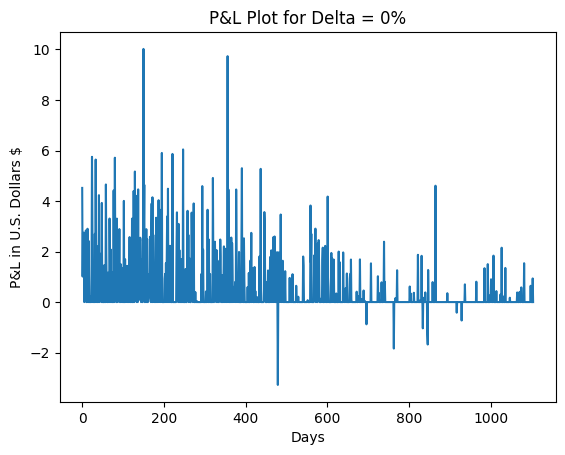

In [49]:
data_test['stoploss_pnl_capital'] = plot_best_delta_strategy(data_test, optimize="capital", tune=False, strategy="stoploss", delta_percents=[0], plot_capital=True)

### Long + Short Strat

In [51]:
def long_short_strat(df, delta_percent=0.0001, cap_alloc_limit=0.5, max_cap_alloc=50000, plot_capital=False, initial_capital=10000):
    pnl = []

    capital = initial_capital

    num_profit_days = 0
    num_loss_days = 0
    num_neutral_days = 0
    capital_list = []
    for day, day_info in df.iterrows():
        # Sell at high else close strat
        predicted_delta = day_info['pred_high_open']
        actual_delta = day_info['actual_high_open']
        pred_low_delta = day_info["pred_low_open"]
        actual_low_delta = day_info["actual_low_open"]

        open = day_info['Open']
        close = day_info['Close']
        delta = delta_percent * open

        # If our prediction is greater than the threshold, trade
        day_return = 0
        day_return_short = 0
        
        # Long Trade
        if predicted_delta >= delta:
            
            # If we hit our high, then sell
            if actual_delta >= predicted_delta:
                day_return = predicted_delta
                # Shouldn't be able to invest beyond max_cap_alloc
                capital_to_invest = min(capital * cap_alloc_limit, max_cap_alloc)

                # Shares to trade
                num_shares = math.floor(capital_to_invest / open)
                capital += num_shares * day_return
                
                pnl.append(predicted_delta)
            else:
                # Else, sell at close
                day_return = open-close
                num_shares = (capital * cap_alloc_limit) / open
                capital += math.floor(num_shares) * day_return
                
                pnl.append(open-close)
        else:
            pnl.append(0)
            num_neutral_days += 1

        if pred_low_delta <= delta:
            if actual_low_delta <= pred_low_delta:
                day_return_short = pred_low_delta * -1
                num_shares = (capital * (1-cap_alloc_limit)) / open
                capital += math.floor(num_shares) * day_return_short
                pnl[-1] += pred_low_delta * -1
            else:
                day_return_short = (open-close) * -1
                num_shares = (capital * (1-cap_alloc_limit)) / open
                capital += math.floor(num_shares) * day_return_short
                pnl[-1] += pred_low_delta * -1

        # if day_return > 0 and day_return_short > 0:
            # print(f"Long Profit : {day_return} and Short Profit : {day_return_short}")


        if day_return + day_return_short > 0:
            num_profit_days += 1
        elif day_return + day_return_short < 0:
            num_loss_days += 1
        else:
            num_neutral_days += 1
        capital_list.append(capital)

    if plot_capital:    
        plt.plot(capital_list)
        plt.title("Capital Over Time")
        plt.xlabel('Days')
        plt.ylabel('Capital in U.S. Dollars $')
        plt.show()
        print("Capital =", capital)
    return pnl, num_profit_days, num_loss_days, num_neutral_days, capital

#### Sharpe Ratio Optimization

Exploring various deltas for the long_short strategy....

Best Delta for long_short Strategy = 0.09000000000000001%,
                ===> Best Sharpe Ratio = 0.988088
                ===> Sum PnL = 9853.761904
                ===> Average PNL = 3.965297$
                ===> Std PNL = 4.013101
                ===> Final Capital = 137629292.879883$
                ===> Profitable Days = 1455
                ===> Lossy Days = 176
                ===> Neutral Days = 1176
                


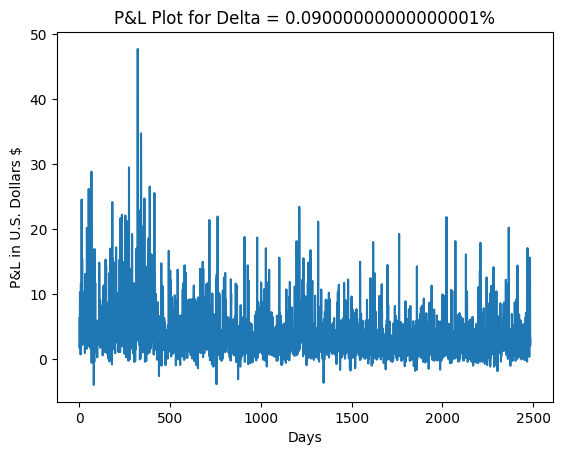

In [52]:
data_train['long_short_pnl'] = plot_best_delta_strategy(data=data_train, strategy="long_short")

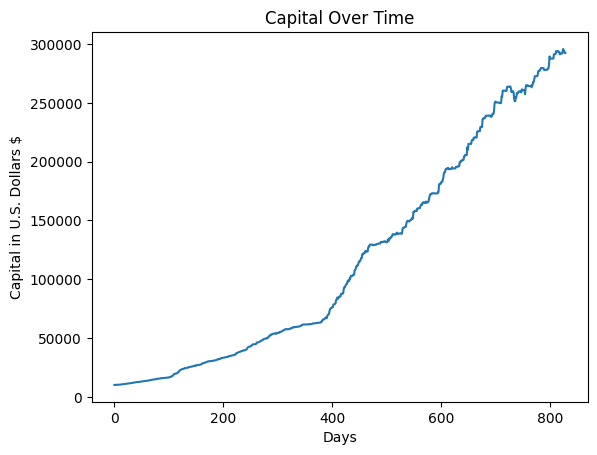

Capital = 292351.20362997486
Delta for long_short Strategy = 0.09%,
        ===> Sharpe Ratio = 1.003533
        ===> Sum PnL = 2992.564095
        ===> Average PNL = 3.609848$
        ===> Std PNL = 3.597140
        ===> Final Capital = 292351.203630$
        ===> Profitable Days = 477
        ===> Lossy Days = 72
        ===> Neutral Days = 395
        


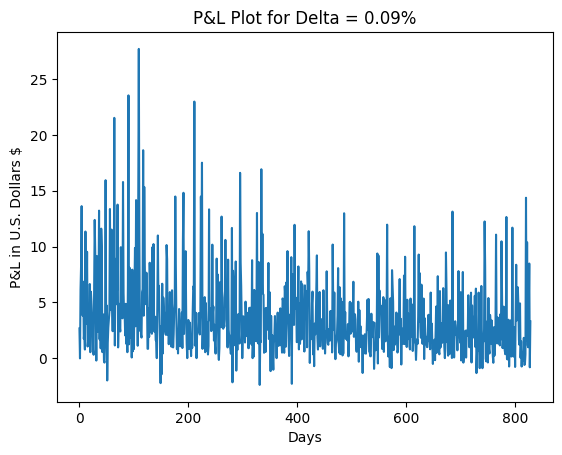

In [53]:
data_val['long_short_pnl'] = plot_best_delta_strategy(data=data_val, tune=False, strategy="long_short", delta_percents=[0.0009], plot_capital=True)

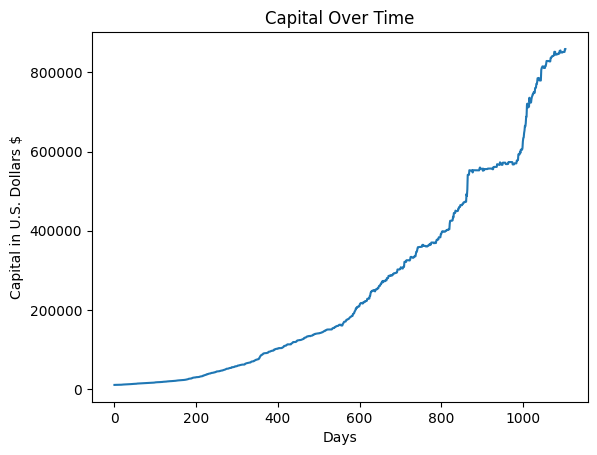

Capital = 859012.7743405906
Delta for long_short Strategy = 0.09%,
        ===> Sharpe Ratio = 1.077063
        ===> Sum PnL = 4448.093162
        ===> Average PNL = 4.025424$
        ===> Std PNL = 3.737408
        ===> Final Capital = 859012.774341$
        ===> Profitable Days = 637
        ===> Lossy Days = 80
        ===> Neutral Days = 540
        


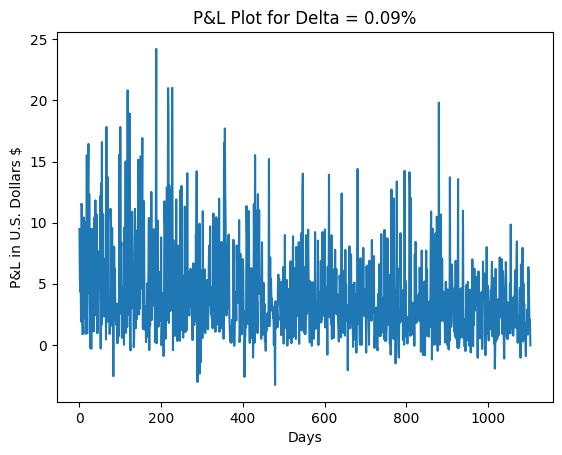

In [54]:
data_test['long_short_pnl'] = plot_best_delta_strategy(data=data_test, tune=False, strategy="long_short", delta_percents=[0.0009], plot_capital=True)

#### Capital Optimization

Exploring various deltas for the long_short strategy....

Best Delta for long_short Strategy = 0.0%,
                ===> Sharpe Ratio = 0.982657
                ===> Sum PnL = 9904.131002
                ===> Average PNL = 3.985566$
                ===> Std PNL = 4.055906
                ===> Best Final Capital = 142055456.364953$
                ===> Profitable Days = 1462
                ===> Lossy Days = 162
                ===> Neutral Days = 1124
                


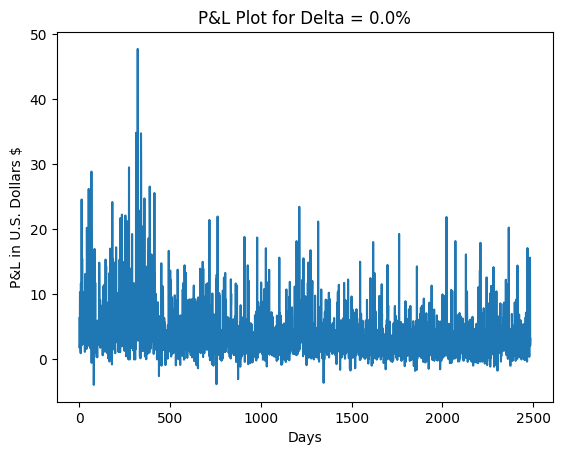

In [55]:
data_train['long_short_pnl_capital'] = plot_best_delta_strategy(data=data_train, strategy="long_short", optimize="capital")

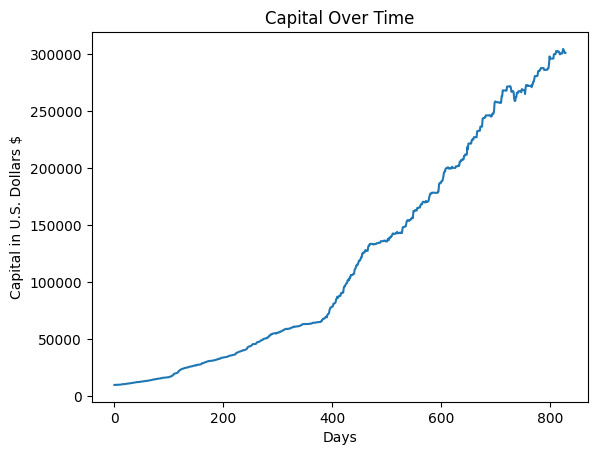

Capital = 300804.4437817294
Delta for long_short Strategy = 0%,
        ===> Sharpe Ratio = 0.985510
        ===> Sum PnL = 3041.140323
        ===> Average PNL = 3.668444$
        ===> Std PNL = 3.722381
        ===> Final Capital = 300804.443782$
        ===> Profitable Days = 483
        ===> Lossy Days = 69
        ===> Neutral Days = 371
        


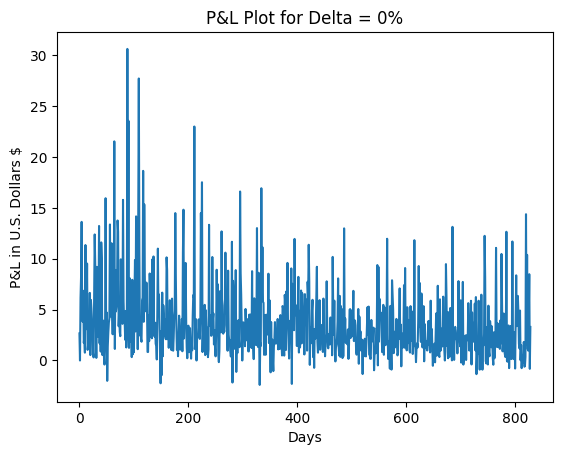

In [57]:
data_val['long_short_pnl_capital'] = plot_best_delta_strategy(data=data_val, optimize="capital", tune=False, strategy="long_short", delta_percents=[0], plot_capital=True)

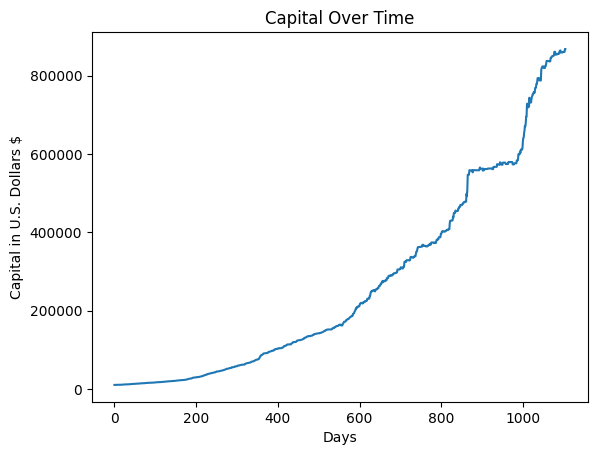

Capital = 868046.9179957076
Delta for long_short Strategy = 0%,
        ===> Sharpe Ratio = 1.081798
        ===> Sum PnL = 4459.759133
        ===> Average PNL = 4.035981$
        ===> Std PNL = 3.730810
        ===> Final Capital = 868046.917996$
        ===> Profitable Days = 643
        ===> Lossy Days = 72
        ===> Neutral Days = 503
        


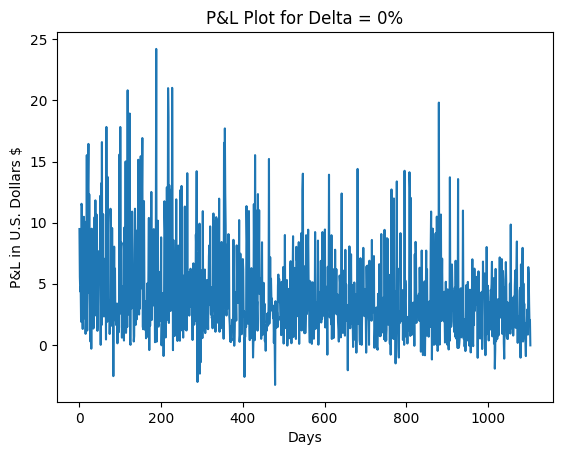

In [58]:
data_test['long_short_pnl_capital'] = plot_best_delta_strategy(data=data_test, optimize="capital", tune=False, strategy="long_short", delta_percents=[0], plot_capital=True)

## Benchmarking and Sanity Checks

In [61]:
data_val["max_profit"] = data_val["High"] - data_val["Low"]
data_test["max_profit"] = data_test["High"] - data_test["Low"]

In [67]:
print('Blind strategy')
print('Validation data:')
print(data_val['max_profit'].describe())
print()
print(data_val['blind_pnl'].describe())
print()
print('Test data:')
print(data_test['max_profit'].describe())
print()
print(data_test['blind_pnl'].describe())


Blind strategy
Validation data:
count    829.000000
mean       5.402726
std        6.030417
min        0.329998
25%        1.700004
50%        3.440002
75%        6.559998
max       45.759994
Name: max_profit, dtype: float64

count    829.000000
mean       1.196571
std        2.535957
min       -6.559998
25%        0.080002
50%        0.781060
75%        1.760010
max       26.880005
Name: blind_pnl, dtype: float64

Test data:
count    1105.000000
mean        5.240941
std         5.758783
min         0.250000
25%         1.679993
50%         3.209999
75%         6.640014
max        45.440002
Name: max_profit, dtype: float64

count    1105.000000
mean        1.272027
std         2.638906
min        -7.679992
25%         0.089998
50%         0.811199
75%         1.702703
max        30.080017
Name: blind_pnl, dtype: float64


In [68]:
print('Stoploss strategy')
print('Validation data:')
print(data_val['max_profit'].describe())
print()
print(data_val['stoploss_pnl'].describe())
print()

print('Test data:')
print(data_test['max_profit'].describe())
print()
print(data_test['stoploss_pnl'].describe())


Stoploss strategy
Validation data:
count    829.000000
mean       5.402726
std        6.030417
min        0.329998
25%        1.700004
50%        3.440002
75%        6.559998
max       45.759994
Name: max_profit, dtype: float64

count    829.000000
mean       2.510152
std        2.526551
min       -2.880005
25%        0.865761
50%        1.561083
75%        3.280466
max       17.400164
Name: stoploss_pnl, dtype: float64

Test data:
count    1105.000000
mean        5.240941
std         5.758783
min         0.250000
25%         1.679993
50%         3.209999
75%         6.640014
max        45.440002
Name: max_profit, dtype: float64

count    1105.000000
mean        2.451811
std         2.268111
min        -3.200012
25%         0.925297
50%         1.589918
75%         3.279388
max        13.057285
Name: stoploss_pnl, dtype: float64


In [69]:
print('Long Short strategy')
print('Validation data:')
print(data_val['max_profit'].describe())
print()
print(data_val['long_short_pnl'].describe())
print()

print('Test data:')
print(data_test['max_profit'].describe())
print()
print(data_test['long_short_pnl'].describe())

Long Short strategy
Validation data:
count    829.000000
mean       5.402726
std        6.030417
min        0.329998
25%        1.700004
50%        3.440002
75%        6.559998
max       45.759994
Name: max_profit, dtype: float64

count    829.000000
mean       4.076034
std        3.785674
min       -0.321138
25%        1.679855
50%        2.873628
75%        5.183254
max       34.592498
Name: long_short_pnl, dtype: float64

Test data:
count    1105.000000
mean        5.240941
std         5.758783
min         0.250000
25%         1.679993
50%         3.209999
75%         6.640014
max        45.440002
Name: max_profit, dtype: float64

count    1105.000000
mean        4.071315
std         3.818166
min         0.009822
25%         1.627892
50%         2.786486
75%         5.144974
max        33.636229
Name: long_short_pnl, dtype: float64


In [70]:
data_train.to_csv('../data/data_train.csv')
data_val.to_csv('../data/data_val.csv')
data_test.to_csv('../data/data_test.csv')